In [1]:
from GraphSummarizers.Coarsener.HeteroCoarsener import HeteroCoarsener
from Datasets.NodeClassification.DBLP import DBLP
from Datasets.NodeClassification.AIFB import AIFB
from Datasets.NodeClassification.TestHetero import TestHeteroSmall, TestHeteroBig
import importlib
import torch
from test_data_converter import dgl_to_pyg_input

/home/robin/thesis/convolution-matching/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

dataset = DBLP() 
original_graph = dataset.load_graph()
R = {
    "author": 0,
    "conference":0,
    "paper":0,
    "term":0,
    "authortopaper":1,
    "conferencetopaper":1,
    "papertoauthor":1,
    "papertoconference":1,
    "papertoterm":1,
    "termtopaper":1
    
}
coarsener = HeteroCoarsener(None,original_graph, 0.5, num_nearest_per_etype=30, num_nearest_neighbors=30,pairs_per_level=100, R=R)
coarsener.init_step()


/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_out = torch.tensor(self.node_degrees[etype]['out'], device=device) + 1.0
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_in  = torch.tensor(self.node_degrees[etype]['in'], device=device)  + 1.0


_create_h_spatial_rgcn 0.24089717864990234
_init_costs 11.193842649459839
_get_union 9.27209997177124
_costs_of_merges 29.716753721237183
_init_merge_graph 0.005583286285400391
_find_lowest_cost_edges 0.0037360191345214844


In [3]:
isNewMerges = True
for i in range(500):
    if not isNewMerges:
        break
    print("--------- step: " , i , "---------" )
    isNewMerges = coarsener.iteration_step()
    

--------- step:  0 ---------
_merge_nodes 0.2420365810394287
_update_merge_graph_nodes_edges 0.15962648391723633
_update_merge_graph_edge_weigths_features 0.005191326141357422
_update_merge_graph_edge_weights_H 0.00577235221862793
_update_merge_graph 0.17380833625793457
_merge_nodes 0.026054859161376953
_update_merge_graph_nodes_edges 0.02353358268737793
_update_merge_graph_edge_weigths_features 0.005098104476928711
_update_merge_graph_edge_weights_H 0.00708770751953125
_update_merge_graph 0.04126119613647461
_merge_nodes 1.3427934646606445
_update_merge_graph_nodes_edges 0.6778929233551025
_update_merge_graph_edge_weigths_features 0.005419492721557617
_update_merge_graph_edge_weights_H 0.0703115463256836
_update_merge_graph 0.7579143047332764
_merge_nodes 0.2673661708831787
_update_merge_graph_nodes_edges 0.18686389923095703
_update_merge_graph_edge_weigths_features 0.0031893253326416016
_update_merge_graph_edge_weights_H 0.0074040889739990234
_update_merge_graph 0.1999213695526123
_f

KeyboardInterrupt: 

In [4]:
coarsend_graph = coarsener.get_coarsend_graph()
coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("author")
labels = coarsener._get_labels(mapping, "author")
coarsend_graph.nodes["author"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))])


In [5]:
original_graph

Graph(num_nodes={'author': 4057, 'conference': 20, 'paper': 14328, 'term': 7723},
      num_edges={('author', 'authortopaper', 'paper'): 19645, ('conference', 'conferencetopaper', 'paper'): 14328, ('paper', 'papertoauthor', 'author'): 19645, ('paper', 'papertoconference', 'conference'): 14328, ('paper', 'papertoterm', 'term'): 85810, ('term', 'termtopaper', 'paper'): 85810},
      metagraph=[('author', 'paper', 'authortopaper'), ('paper', 'author', 'papertoauthor'), ('paper', 'conference', 'papertoconference'), ('paper', 'term', 'papertoterm'), ('conference', 'paper', 'conferencetopaper'), ('term', 'paper', 'termtopaper')])

In [6]:
coarsend_graph

Graph(num_nodes={'author': 3257, 'conference': 9, 'paper': 11528, 'term': 6223},
      num_edges={('author', 'authortopaper', 'paper'): 19273, ('conference', 'conferencetopaper', 'paper'): 13555, ('paper', 'papertoauthor', 'author'): 19273, ('paper', 'papertoconference', 'conference'): 13555, ('paper', 'papertoterm', 'term'): 80906, ('term', 'termtopaper', 'paper'): 80906},
      metagraph=[('author', 'paper', 'authortopaper'), ('paper', 'author', 'papertoauthor'), ('paper', 'conference', 'papertoconference'), ('paper', 'term', 'papertoterm'), ('conference', 'paper', 'conferencetopaper'), ('term', 'paper', 'termtopaper')])

In [7]:
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 

ratio 0.8043860992039191


In [8]:
original_data, o_x_dict, o_edge_index_dict, o_node_types, o_edge_types = dgl_to_pyg_input(original_graph)
coarsened_data, c_x_dict, c_edge_index_dict, c_node_types, c_edge_types = dgl_to_pyg_input(coarsend_graph)

In [9]:

mapping_paper = coarsener.get_mapping("paper")

In [11]:
mapping_author_array = torch.tensor([v for k,v in mapping.items()])


mapping_paper_array = torch.tensor([v for k,v in mapping_paper.items()])


In [12]:
src_all_orig = original_graph.edges(etype="authortopaper")[0]
dst_all_orig = original_graph.edges(etype="authortopaper")[1]
for src_orig, dst_orig in zip(src_all_orig, dst_all_orig):
    src_c = mapping_author_array[src_orig.item()]
    dst_c = mapping_paper_array[dst_orig.item()]
    edges = coarsend_graph.edge_ids(src_c, dst_c, etype="authortopaper")
    assert len(edges) != 0, "warning"
    

In [10]:
import torch
import numpy as np
from torch_geometric.data import HeteroData

# Assuming you already have your hetero_data object
# hetero_data = HeteroData(...)

def create_train_val_test_masks(hetero_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, random_state=42, target_node_type='author'):
    """
    Create training, validation, and testing masks for author nodes.
    
    Args:
        hetero_data: HeteroData object
        train_ratio: Ratio of training data
        val_ratio: Ratio of validation data
        test_ratio: Ratio of testing data
        random_state: Random seed for reproducibility
    
    Returns:
        HeteroData object with train_mask, val_mask, and test_mask added to author nodes
    """
    # Ensure ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
    
    # Get number of author nodes
    num_authors = hetero_data[target_node_type]["feat"].size(0)
    
    # Create random permutation of node indices
    np.random.seed(random_state)
    indices = np.random.permutation(num_authors)
    
    # Calculate split sizes
    train_size = int(num_authors * train_ratio)
    val_size = int(num_authors * val_ratio)
    
    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Create boolean masks
    train_mask = torch.zeros(num_authors, dtype=torch.bool)
    val_mask = torch.zeros(num_authors, dtype=torch.bool)
    test_mask = torch.zeros(num_authors, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Add masks to hetero_data
    hetero_data[target_node_type].train_mask = train_mask
    hetero_data[target_node_type].val_mask = val_mask
    hetero_data[target_node_type].test_mask = test_mask
    
    # Print split statistics
    print(f"Split statistics:")
    print(f"  Training: {train_mask.sum()} nodes ({train_mask.sum() / num_authors:.2%})")
    print(f"  Validation: {val_mask.sum()} nodes ({val_mask.sum() / num_authors:.2%})")
    print(f"  Testing: {test_mask.sum()} nodes ({test_mask.sum() / num_authors:.2%})")
    
    return hetero_data

# Example usage
seed = 46 # 44
original_data =  create_train_val_test_masks(original_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, target_node_type='author', random_state=seed)
coarsened_data = create_train_val_test_masks(coarsened_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, target_node_type='author', random_state=seed)

# Accessing the masks
# train_nodes = hetero_data['author'].x[hetero_data['author'].train_mask]
# val_nodes = hetero_data['author'].x[hetero_data['author'].val_mask]
# test_nodes = hetero_data['author'].x[hetero_data['author'].test_mask]


Split statistics:
  Training: 405 nodes (9.98%)
  Validation: 405 nodes (9.98%)
  Testing: 3247 nodes (80.03%)
Split statistics:
  Training: 325 nodes (9.98%)
  Validation: 325 nodes (9.98%)
  Testing: 2607 nodes (80.04%)


In [11]:
from torch_sparse import SparseTensor

def build_adj_t_dict(data):
    adj_t_dict = {}
    for (src_type, rel, dst_type), edge_index in data.edge_index_dict.items():
        src_idx = edge_index[0]                   # sources
        dst_idx = edge_index[1]                   # destinations
        N_src   = data[src_type].num_nodes
        N_dst   = data[dst_type].num_nodes

        # row = destination, col = source, shape = (N_dst, N_src)
        adj_t = SparseTensor(row=dst_idx,
                             col=src_idx,
                             sparse_sizes=(N_dst, N_src))
        adj_t_dict[(src_type, rel, dst_type)] = adj_t

    return adj_t_dict

Epoch 1:
  Original Graph - Loss: 1557.1453, Accuracy: 0.2763
  Coarsened Graph - Loss: 2550.5708, Accuracy: 0.1975
  Inverted Coarsened - Accuracy: 0.2359

Epoch 11:
  Original Graph - Loss: 336.9180, Accuracy: 0.1783
  Coarsened Graph - Loss: 4512.2798, Accuracy: 0.3084
  Inverted Coarsened - Accuracy: 0.2795

Epoch 21:
  Original Graph - Loss: 1.3710, Accuracy: 0.3151
  Coarsened Graph - Loss: 1339.0640, Accuracy: 0.3172
  Inverted Coarsened - Accuracy: 0.3020

Epoch 31:
  Original Graph - Loss: 1.3453, Accuracy: 0.3144
  Coarsened Graph - Loss: 1056.6759, Accuracy: 0.3172
  Inverted Coarsened - Accuracy: 0.3020

Epoch 41:
  Original Graph - Loss: 1.3035, Accuracy: 0.4515
  Coarsened Graph - Loss: 295.6335, Accuracy: 0.3172
  Inverted Coarsened - Accuracy: 0.3020

Epoch 51:
  Original Graph - Loss: 1.2420, Accuracy: 0.5306
  Coarsened Graph - Loss: 79.5430, Accuracy: 0.1975
  Inverted Coarsened - Accuracy: 0.2359

Epoch 61:
  Original Graph - Loss: 1.1431, Accuracy: 0.5833
  Coarsen

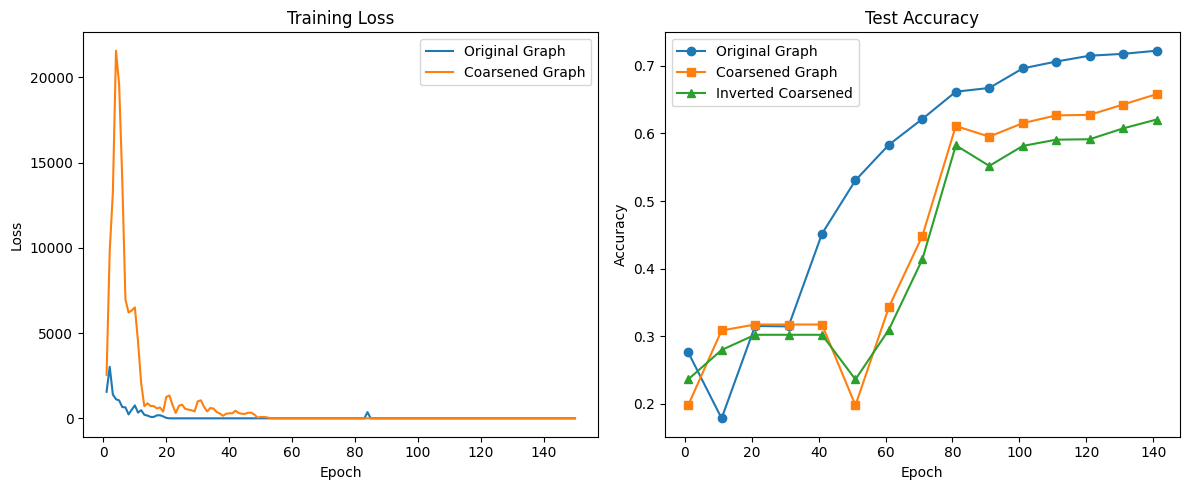

Final Performance Comparison:
Original Graph Accuracy: 0.7225
Coarsened Graph Accuracy: 0.6582
Inverted Coarsened Accuracy: 0.6207


In [12]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
from Models.GNNs.HGCN import ImprovedHeteroGNN, HeteroSGC
from torch_geometric.utils import to_torch_csr_tensor

original_x_dict = o_x_dict
coarsened_x_dict = c_x_dict
o_metadata = (o_node_types, o_edge_types)
c_metadata=(c_node_types, c_edge_types)
#original_x_dict.update({"conference": torch.zeros((original_data["conference"]["num_nodes"], 1))})# = 0  #= 0#
#coarsened_x_dict.update({"conference": torch.zeros((coarsened_data["conference"]["num_nodes"], 1))})# = 0  #= 0#

#num_classes = len(original_data["author"]["label"].unique())

target_node_type = "author"
# Your existing model definition
num_layers = 3

model_original = HeteroSGC(
    hidden_channels    = 64,
    out_channels       = 4,
    num_layers         = num_layers,
    edge_types         = o_edge_types,
    node_types         = o_node_types,
    target_node_type   = target_node_type,
    alpha              = 0.01,
)

model_coarsened = HeteroSGC(
    hidden_channels    = 64,
    out_channels       = 4,
    num_layers         = num_layers,
    edge_types         = c_edge_types,
    node_types         = c_node_types,
    target_node_type   = target_node_type,
    alpha              = 0.01,
)

# Optimizers
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)
optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)


# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for orig_node, coarsened_node in inversion_map.items():
        if not test_mask[coarsened_node]:
            continue
        coarse_pred = coarsened_pred[coarsened_node]
        orig_label = original_labels[orig_node]
        #print(coarse_pred, orig_label)

        correct = (coarse_pred == orig_label)
    
                
        if correct:
            correct_count += 1
     #   else:
      #      print(f"Mismatch: Coarsened Node {coarsened_node} predicted {coarse_pred}, Original Node {orig_node} label {orig_label}")
        total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0

# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    original_adj_t_dict = original_adj_t_dict  = build_adj_t_dict(original_data)
    #print(original_x_original_data.edge_index_dict)
    out = model_original(original_x_dict, original_adj_t_dict)      # [N_orig_author, 4]
    # either wrap logits in log‐softmax or switch to cross_entropy:
    loss = F.cross_entropy(
        out[ original_data["author"].train_mask ], 
        original_data["author"].label[ original_data["author"].train_mask ]
    )
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    coarsend_adj_t_dict = build_adj_t_dict(coarsened_data)
    out = model_coarsened(coarsened_x_dict, coarsend_adj_t_dict)  # [N_coarse_author, 4]
    loss = F.cross_entropy(
        out[ coarsened_data["author"].train_mask ],
        coarsened_data["author"].label[ coarsened_data["author"].train_mask ]
    )

    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        original_adj_t_dict = original_adj_t_dict  = build_adj_t_dict(original_data)
        out  = model_original(original_x_dict, original_adj_t_dict)
        pred = out.argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = ( pred[ original_data["author"].test_mask ] ==
               original_data["author"].label[ original_data["author"].test_mask ] )
        acc = int(correct.sum()) / int(original_data[target_node_type].test_mask.sum())
        return acc

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        coarsend_adj_t_dict = build_adj_t_dict(coarsened_data)
        out  = model_coarsened(coarsened_x_dict, coarsend_adj_t_dict)
        pred = out.argmax(dim=1)
        mask   = coarsened_data[target_node_type].test_mask      # a BoolTensor of shape [N_coarse_nodes]
        labels = coarsened_data[target_node_type].label           # a LongTensor of shape [N_coarse_nodes]

        # compute the accuracy:
        correct     = (pred[mask] == labels[mask]).sum().item()
        total_tests = mask.sum().item()
        coarsened_acc = correct / total_tests
        inverted_acc = 0
        
        # Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = apply_inversion_mapping(
             pred,  
             mapping,
             original_data[target_node_type]["label"], 
             coarsened_data[target_node_type].test_mask
         )
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}
epochs = 150
for epoch in range(epochs):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, epochs, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)

Epoch 1:
  Original Graph - Loss: 1.4587, Accuracy: 0.2944
  Coarsened Graph - Loss: 1.5136, Accuracy: 0.3172
  Inverted Coarsened - Accuracy: 0.3020

Epoch 11:
  Original Graph - Loss: 1.3641, Accuracy: 0.3465
  Coarsened Graph - Loss: 1.3599, Accuracy: 0.3498
  Inverted Coarsened - Accuracy: 0.3293

Epoch 21:
  Original Graph - Loss: 1.2567, Accuracy: 0.3936
  Coarsened Graph - Loss: 1.2611, Accuracy: 0.5627
  Inverted Coarsened - Accuracy: 0.5080

Epoch 31:
  Original Graph - Loss: 0.8429, Accuracy: 0.6360
  Coarsened Graph - Loss: 1.0761, Accuracy: 0.6732
  Inverted Coarsened - Accuracy: 0.5876

Epoch 41:
  Original Graph - Loss: 0.8832, Accuracy: 0.6797
  Coarsened Graph - Loss: 0.7181, Accuracy: 0.7783
  Inverted Coarsened - Accuracy: 0.7243



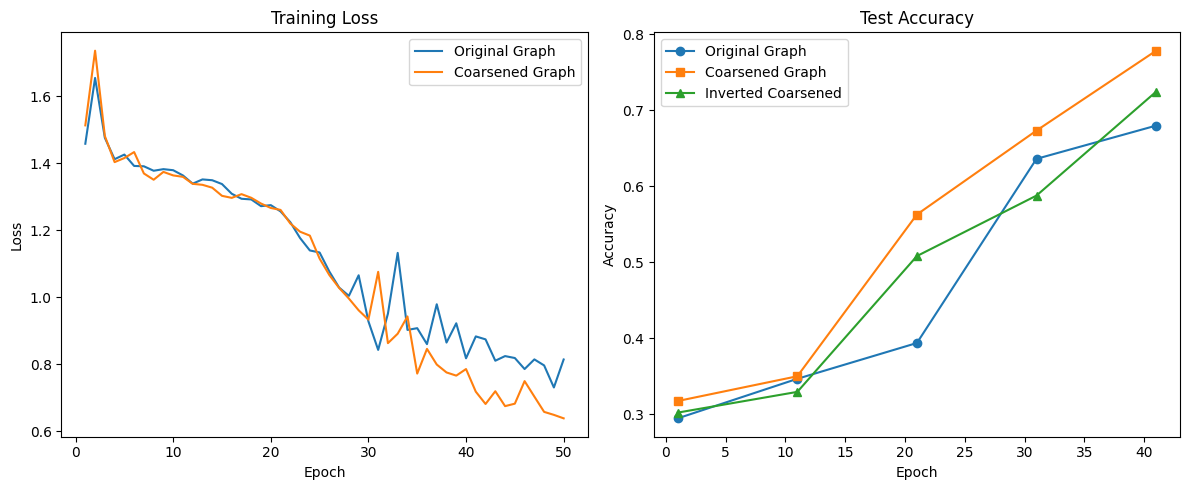

Final Performance Comparison:
Original Graph Accuracy: 0.6797
Coarsened Graph Accuracy: 0.7783
Inverted Coarsened Accuracy: 0.7243


In [13]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
from Models.GNNs.HGCN import ImprovedHeteroGNN


original_x_dict = o_x_dict
coarsened_x_dict = c_x_dict
o_metadata = (o_node_types, o_edge_types)
c_metadata=(c_node_types, c_edge_types)
#original_x_dict.update({"conference": torch.zeros((original_data["conference"]["num_nodes"], 1))})# = 0  #= 0#
#coarsened_x_dict.update({"conference": torch.zeros((coarsened_data["conference"]["num_nodes"], 1))})# = 0  #= 0#

#num_classes = len(original_data["author"]["label"].unique())

target_node_type = "author"
# Your existing model definition
model_original = ImprovedHeteroGNN(metadata=o_metadata,target_feat=target_node_type, x_dict= original_x_dict ,num_classes= 4,hidden_channels=64, with_non_linear= False)
model_coarsened = ImprovedHeteroGNN(metadata=c_metadata, target_feat=target_node_type,x_dict= coarsened_x_dict,num_classes= 4, hidden_channels=64, with_non_linear= False)

# Optimizers
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)
optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)


# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for orig_node, coarsened_node in inversion_map.items():
        if not test_mask[coarsened_node]:
            continue
        coarse_pred = coarsened_pred[coarsened_node]
        orig_label = original_labels[orig_node]
        #print(coarse_pred, orig_label)

        correct = (coarse_pred == orig_label)
    
                
        if correct:
            correct_count += 1
     #   else:
      #      print(f"Mismatch: Coarsened Node {coarsened_node} predicted {coarse_pred}, Original Node {orig_node} label {orig_label}")
        total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0

# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    
    #print(original_x_original_data.edge_index_dict)
    out = model_original(original_x_dict, original_data.edge_index_dict)
    loss = F.nll_loss(
        out[target_node_type][original_data[target_node_type].train_mask], 
        original_data[target_node_type]["label"][original_data[target_node_type].train_mask]
    )
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
    loss = F.nll_loss(
        out[target_node_type][coarsened_data[target_node_type].train_mask], 
        coarsened_data[target_node_type]["label"][coarsened_data[target_node_type].train_mask]
    )
    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        out = model_original(original_x_dict, original_data.edge_index_dict)
        pred = out[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = pred[original_data[target_node_type].test_mask] == original_data[target_node_type]["label"][original_data[target_node_type].test_mask]
        acc = int(correct.sum()) / int(original_data[target_node_type].test_mask.sum())
        return acc

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
        pred = out[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        coarsened_acc = int(
            (pred[coarsened_data[target_node_type].test_mask] == 
             coarsened_data[target_node_type]["label"][coarsened_data[target_node_type].test_mask]).sum()
        ) / int(coarsened_data[target_node_type].test_mask.sum())
        inverted_acc = 0
        
        # Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = apply_inversion_mapping(
             pred,  
             mapping,
             original_data[target_node_type]["label"], 
             coarsened_data[target_node_type].test_mask
         )
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}

for epoch in range(50):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, 50, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)